<a href="https://colab.research.google.com/github/Lorenzo-B/chaos-biocv/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!git clone https://github.com/Lorenzo-B/chaos-biocv.git

Cloning into 'chaos-biocv'...
remote: Enumerating objects: 3151, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 3151 (delta 0), reused 15 (delta 0), pack-reused 3136
Receiving objects: 100% (3151/3151), 96.12 MiB | 20.26 MiB/s, done.
Resolving deltas: 100% (239/239), done.
Updating files: 100% (3197/3197), done.


In [7]:
!pip install pydicom

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 9.4 MB/s eta 0:00:00


In [45]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
%cd chaos-biocv/chaos_dataset/
!tfds build
%cd ../..

/content/chaos-biocv/chaos_dataset
INFO[build.py]: Loading dataset  from path: /content/chaos-biocv/chaos_dataset/chaos_dataset_dataset_builder.py
2023-12-22 11:54:05.392082: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-22 11:54:05.392130: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-22 11:54:05.393386: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-22 11:54:05.400192: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instruc

In [57]:
import tensorflow as tf
import keras as keras
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
import numpy as np

import pydicom
from pathlib import Path



In [58]:
tf.config.run_functions_eagerly(True)

In [59]:
def resize(input_image, input_mask):
   input_image = tf.image.resize(input_image, (128, 128))
   input_mask = tf.image.resize(input_mask, (128, 128), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

   return input_image, input_mask

def normalize(input_image: tf.Tensor, input_mask: tf.Tensor):
  #  input_image = tf.cast(input_image, tf.float32) / 255.0
   #  input_mask = tf.cast(input_mask, tf.float32) / 255.0
   #print(input_mask.numpy())

  #  input_mask -= 1

   return input_image, input_mask

class Augment(tf.keras.layers.Layer):
    def __init__(self, seed=42):
        super().__init__()
        # both use the same seed, so they'll make the same random changes.

        self.augment_inputs = keras.layers.RandomFlip(mode="vertical", seed=seed)
        self.augment_masks = keras.layers.RandomFlip(mode="vertical", seed=seed)

    def call(self, inputs, labels):
        inputs = self.augment_inputs(inputs)
        labels = self.augment_masks(labels)
        return inputs, labels


def load_image(datapoint):
   input_image = datapoint["image"]
   input_mask = datapoint["segmentation_mask"]

   input_image, input_mask = resize(input_image, input_mask)
   input_image, input_mask = normalize(input_image, input_mask)

   return input_image, input_mask


In [60]:
dataset, info = tfds.load('chaos_dataset:1.0.12', with_info=True)

TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 32
BUFFER_SIZE = TRAIN_LENGTH
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [61]:
info.splits['train'].num_examples

1142

In [62]:
train_dataset = dataset["train"].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
validation_dataset = dataset["validation"].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = dataset["test"].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

In [63]:
train_batches = (
    train_dataset
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

validation_batches = validation_dataset.batch(BATCH_SIZE)
test_batches = test_dataset.batch(BATCH_SIZE)

In [64]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        # plt.imshow(tf.keras.utils.array_to_img(display_list[i]), cmap="gray")
        plt.axis('off')
    plt.show()

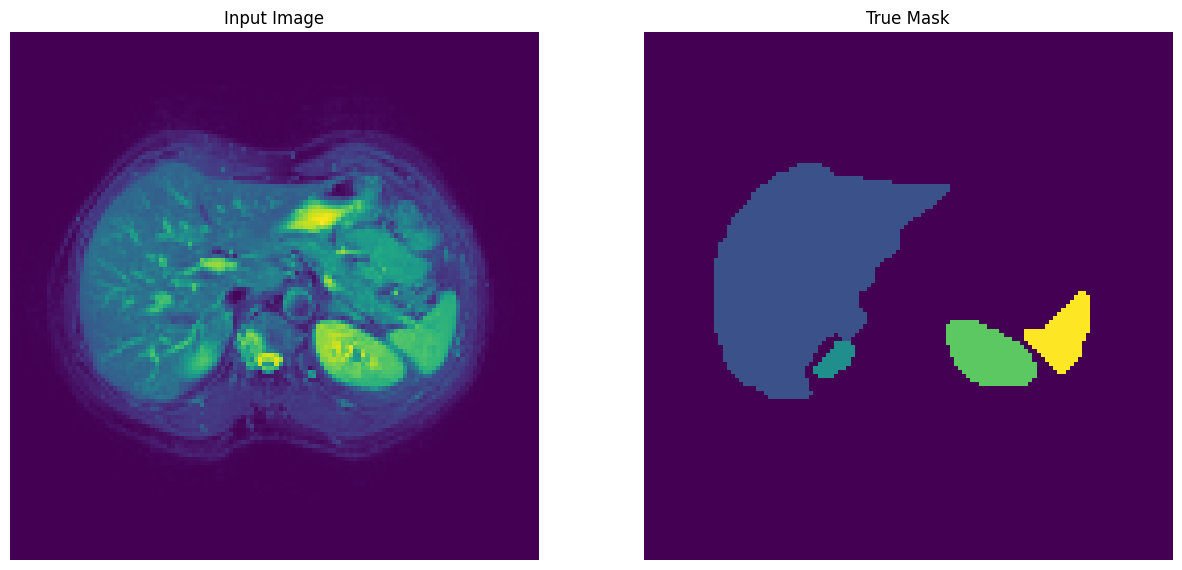

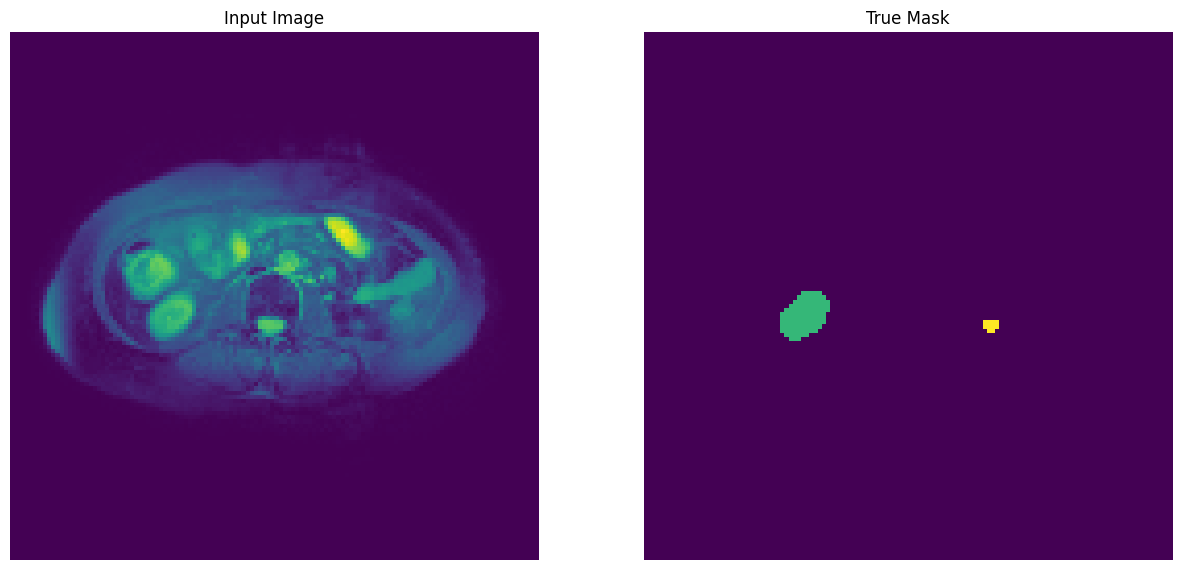

In [65]:
for images, masks in train_batches.take(2):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])

### U-Net Model ###


In [66]:
def double_conv_block(x, n_filters):

    # Conv2D then ReLU activation
    x = keras.layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    # Conv2D then ReLU activation
    x = keras.layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)

    return x

def downsample_block(x, n_filters):
    f = double_conv_block(x, n_filters)
    p = keras.layers.MaxPool2D(2)(f)
    p = keras.layers.Dropout(0.3)(p)

    return f, p

def upsample_block(x, conv_features, n_filters):
    # upsample
    x = keras.layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
    # concatenate
    x = keras.layers.concatenate([x, conv_features])
    # dropout
    x = keras.layers.Dropout(0.3)(x)
    # Conv2D twice with ReLU activation
    x = double_conv_block(x, n_filters)

    return x

In [67]:
def build_unet_model():

    # inputs
    inputs = keras.layers.Input(shape=(128,128,1))

    # encoder: contracting path - downsample
    # 1 - downsample
    f1, p1 = downsample_block(inputs, 64)
    # 2 - downsample
    f2, p2 = downsample_block(p1, 128)
    # 3 - downsample
    f3, p3 = downsample_block(p2, 256)
    # 4 - downsample
    f4, p4 = downsample_block(p3, 512)

    # 5 - bottleneck
    bottleneck = double_conv_block(p4, 1024)

    # decoder: expanding path - upsample
    # 6 - upsample
    u6 = upsample_block(bottleneck, f4, 512)
    # 7 - upsample
    u7 = upsample_block(u6, f3, 256)
    # 8 - upsample
    u8 = upsample_block(u7, f2, 128)
    # 9 - upsample
    u9 = upsample_block(u8, f1, 64)

    # last = tf.keras.layers.Conv2DTranspose(
    #   filters=5, kernel_size=3, strides=2,
    #   padding='same')  #64x64 -> 128x128
    # outputs = last(u9)

    # outputs
    outputs = keras.layers.Conv2D(filters=5, kernel_size=1, padding="same", activation = "softmax")(u9)

    # unet model with Keras Functional API
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

    return unet_model

In [68]:
unet_model = build_unet_model()

In [69]:
unet_model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 conv2d_76 (Conv2D)          (None, 128, 128, 64)         640       ['input_5[0][0]']             
                                                                                                  
 conv2d_77 (Conv2D)          (None, 128, 128, 64)         36928     ['conv2d_76[0][0]']           
                                                                                                  
 max_pooling2d_16 (MaxPooli  (None, 64, 64, 64)           0         ['conv2d_77[0][0]']           
 ng2D)                                                                                        

In [70]:
unet_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [71]:
def create_mask(pred_mask):
    pred_mask = tf.math.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [72]:
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = unet_model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
                create_mask(unet_model.predict(sample_image[tf.newaxis, ...]))])

1/1 [==============================] - 0s 68ms/step


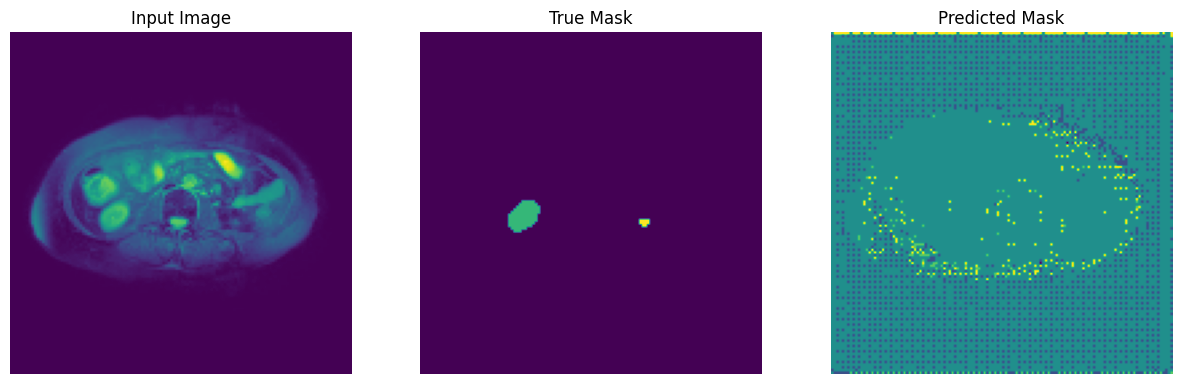

In [73]:
show_predictions()

In [74]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        #clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [75]:
def add_sample_weights(image, label):
  # The weights for each class, with the constraint that:
  #     sum(class_weights) == 1.0
  class_weights = tf.constant([1.0, 10.0, 5.0, 6.0, 6.0])
  class_weights = class_weights/tf.reduce_sum(class_weights)

  # Create an image of `sample_weights` by using the label at each pixel as an
  # index into the `class weights` .
  sample_weights = tf.gather(class_weights, indices=tf.cast(label, tf.int32))

  return image, label, sample_weights

In [76]:
from keras.callbacks import ModelCheckpoint

Epoch 1/20
35/35 [==============================] - ETA: 0s - loss: 0.0317 - accuracy: 0.8459
Epoch 1: loss improved from inf to 0.03166, saving model to chaos19_unet.keras
1/1 [==============================] - 0s 61ms/step


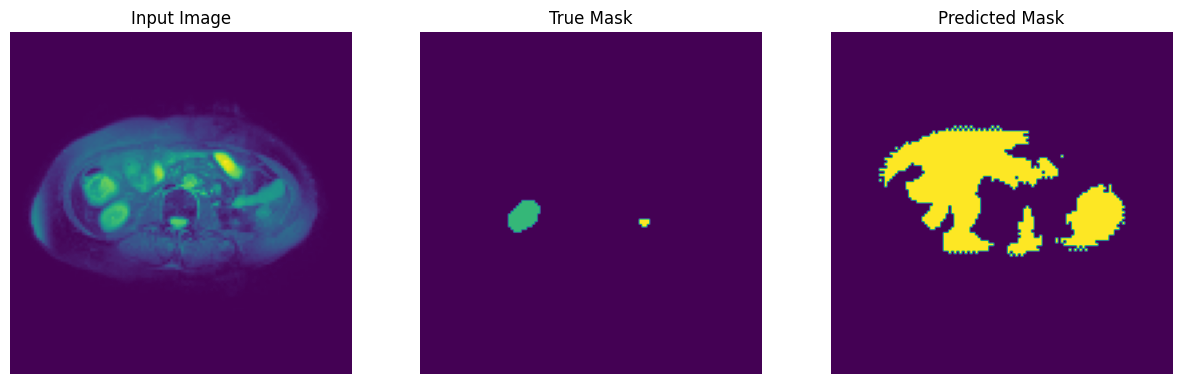


Sample Prediction after epoch 1

35/35 [==============================] - 23s 665ms/step - loss: 0.0317 - accuracy: 0.8459 - val_loss: 0.2678 - val_accuracy: 0.8984
Epoch 2/20
35/35 [==============================] - ETA: 0s - loss: 0.0219 - accuracy: 0.9275
Epoch 2: loss improved from 0.03166 to 0.02195, saving model to chaos19_unet.keras
1/1 [==============================] - 0s 45ms/step


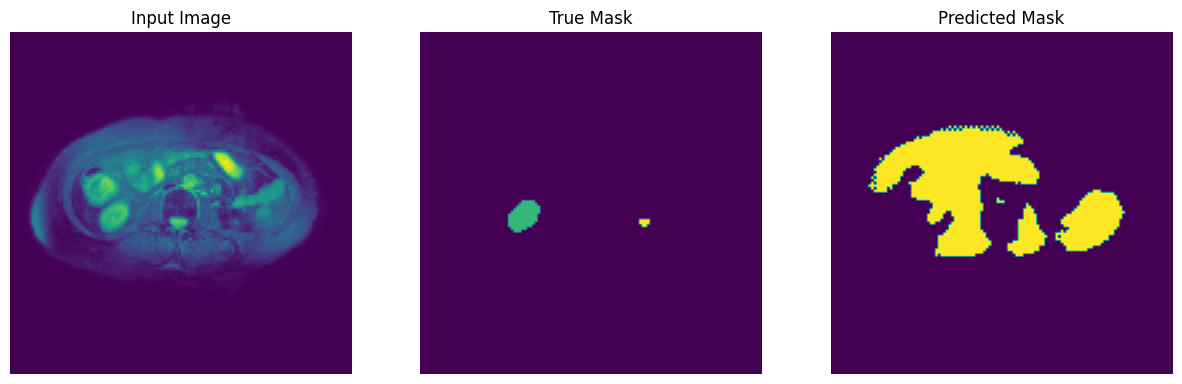


Sample Prediction after epoch 2

35/35 [==============================] - 28s 804ms/step - loss: 0.0219 - accuracy: 0.9275 - val_loss: 0.2761 - val_accuracy: 0.9023
Epoch 3/20
35/35 [==============================] - ETA: 0s - loss: 0.0173 - accuracy: 0.9378
Epoch 3: loss improved from 0.02195 to 0.01729, saving model to chaos19_unet.keras
1/1 [==============================] - 0s 47ms/step


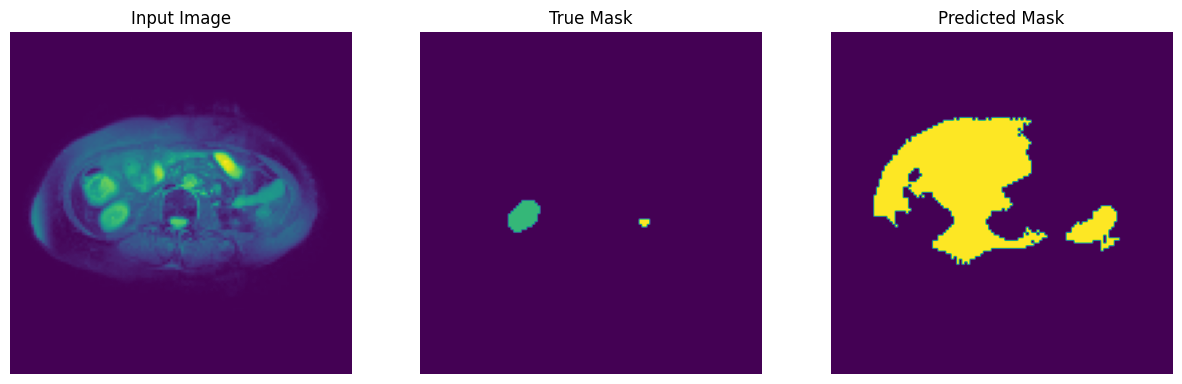


Sample Prediction after epoch 3

35/35 [==============================] - 22s 628ms/step - loss: 0.0173 - accuracy: 0.9378 - val_loss: 0.3171 - val_accuracy: 0.8916
Epoch 4/20
35/35 [==============================] - ETA: 0s - loss: 0.0129 - accuracy: 0.9450
Epoch 4: loss improved from 0.01729 to 0.01293, saving model to chaos19_unet.keras
1/1 [==============================] - 0s 66ms/step


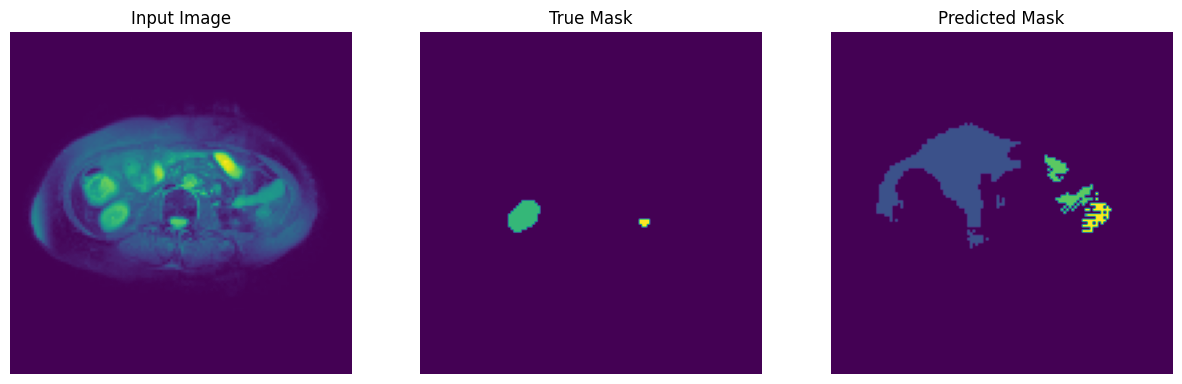


Sample Prediction after epoch 4

35/35 [==============================] - 22s 640ms/step - loss: 0.0129 - accuracy: 0.9450 - val_loss: 0.2111 - val_accuracy: 0.9306
Epoch 5/20
35/35 [==============================] - ETA: 0s - loss: 0.0113 - accuracy: 0.9429
Epoch 5: loss improved from 0.01293 to 0.01131, saving model to chaos19_unet.keras
1/1 [==============================] - 0s 45ms/step


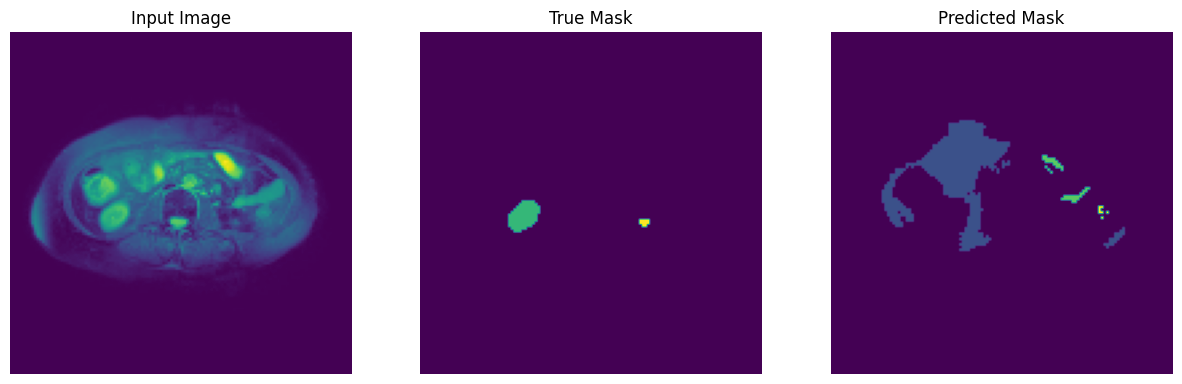


Sample Prediction after epoch 5

35/35 [==============================] - 22s 631ms/step - loss: 0.0113 - accuracy: 0.9429 - val_loss: 0.1577 - val_accuracy: 0.9437
Epoch 6/20
35/35 [==============================] - ETA: 0s - loss: 0.0098 - accuracy: 0.9469
Epoch 6: loss improved from 0.01131 to 0.00983, saving model to chaos19_unet.keras
1/1 [==============================] - 0s 44ms/step


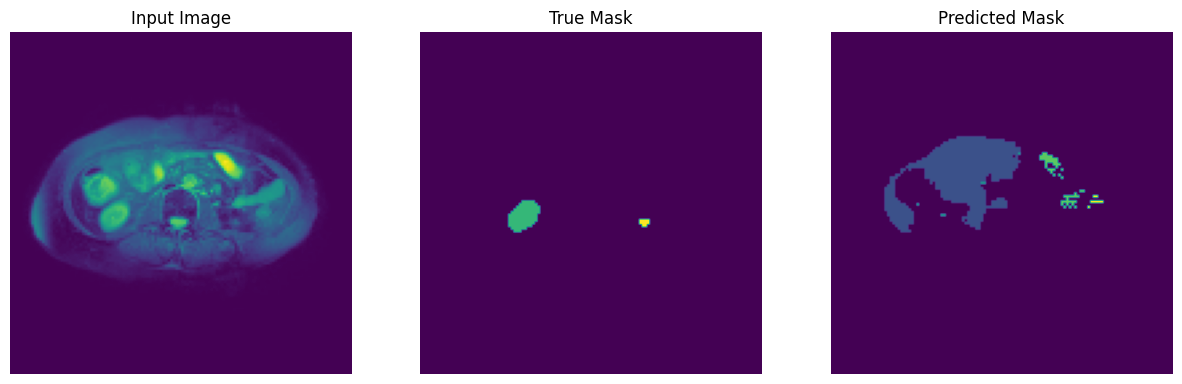


Sample Prediction after epoch 6

35/35 [==============================] - 22s 633ms/step - loss: 0.0098 - accuracy: 0.9469 - val_loss: 0.1542 - val_accuracy: 0.9421
Epoch 7/20
35/35 [==============================] - ETA: 0s - loss: 0.0087 - accuracy: 0.9490
Epoch 7: loss improved from 0.00983 to 0.00875, saving model to chaos19_unet.keras
1/1 [==============================] - 0s 46ms/step


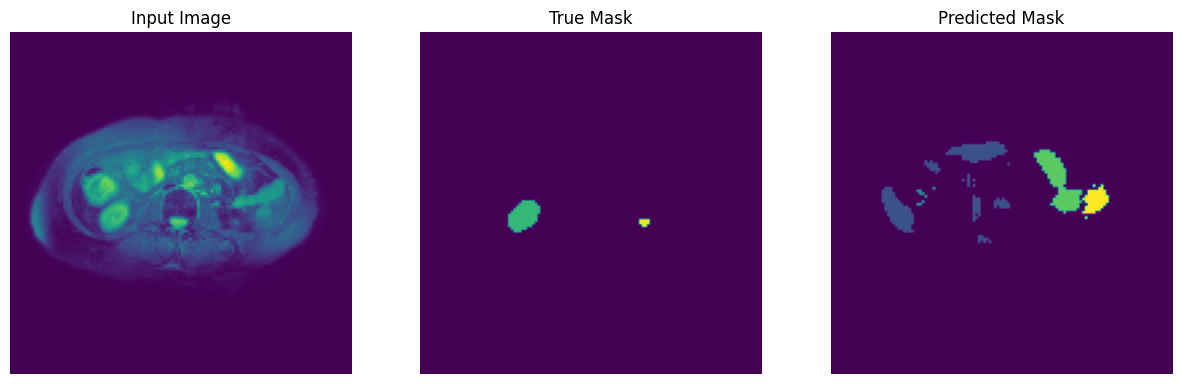


Sample Prediction after epoch 7

35/35 [==============================] - 28s 797ms/step - loss: 0.0087 - accuracy: 0.9490 - val_loss: 0.1553 - val_accuracy: 0.9310
Epoch 8/20
35/35 [==============================] - ETA: 0s - loss: 0.0078 - accuracy: 0.9553
Epoch 8: loss improved from 0.00875 to 0.00777, saving model to chaos19_unet.keras
1/1 [==============================] - 0s 46ms/step


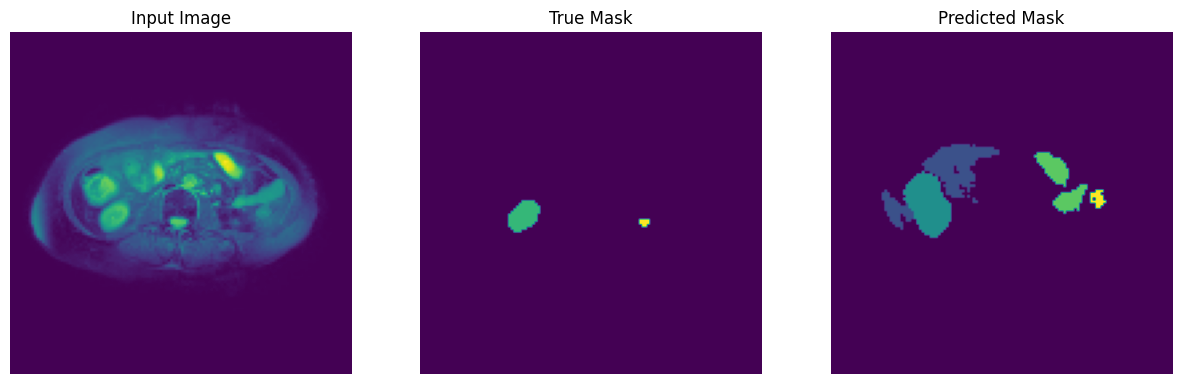


Sample Prediction after epoch 8

35/35 [==============================] - 22s 638ms/step - loss: 0.0078 - accuracy: 0.9553 - val_loss: 0.1464 - val_accuracy: 0.9356
Epoch 9/20
35/35 [==============================] - ETA: 0s - loss: 0.0069 - accuracy: 0.9554
Epoch 9: loss improved from 0.00777 to 0.00691, saving model to chaos19_unet.keras
1/1 [==============================] - 0s 44ms/step


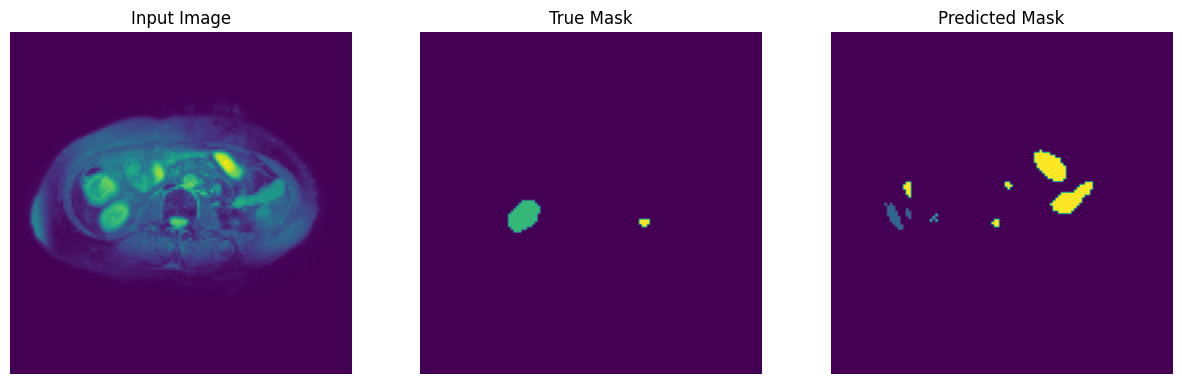


Sample Prediction after epoch 9

35/35 [==============================] - 23s 650ms/step - loss: 0.0069 - accuracy: 0.9554 - val_loss: 0.0900 - val_accuracy: 0.9607
Epoch 10/20
35/35 [==============================] - ETA: 0s - loss: 0.0067 - accuracy: 0.9582
Epoch 10: loss improved from 0.00691 to 0.00672, saving model to chaos19_unet.keras
1/1 [==============================] - 0s 43ms/step


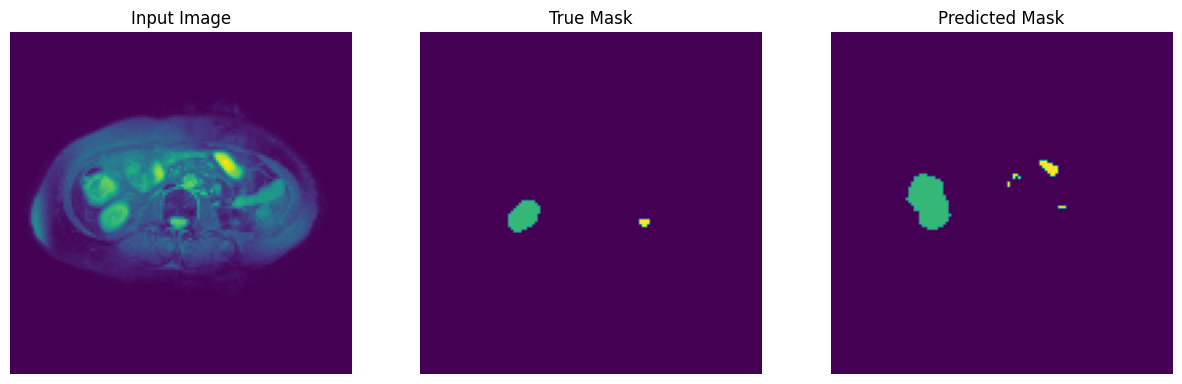


Sample Prediction after epoch 10

35/35 [==============================] - 27s 785ms/step - loss: 0.0067 - accuracy: 0.9582 - val_loss: 0.0726 - val_accuracy: 0.9703
Epoch 11/20
35/35 [==============================] - ETA: 0s - loss: 0.0054 - accuracy: 0.9662
Epoch 11: loss improved from 0.00672 to 0.00537, saving model to chaos19_unet.keras
1/1 [==============================] - 0s 45ms/step


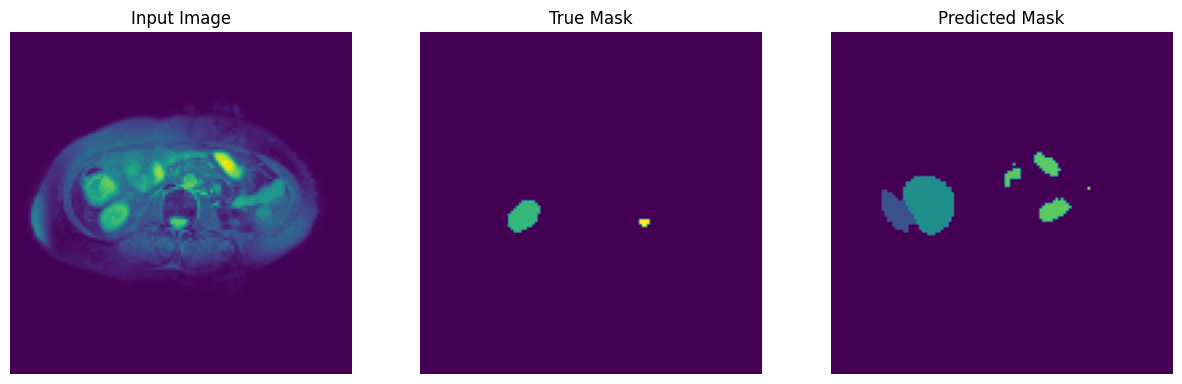


Sample Prediction after epoch 11

35/35 [==============================] - 22s 643ms/step - loss: 0.0054 - accuracy: 0.9662 - val_loss: 0.1033 - val_accuracy: 0.9611
Epoch 12/20
35/35 [==============================] - ETA: 0s - loss: 0.0048 - accuracy: 0.9702
Epoch 12: loss improved from 0.00537 to 0.00483, saving model to chaos19_unet.keras
1/1 [==============================] - 0s 43ms/step


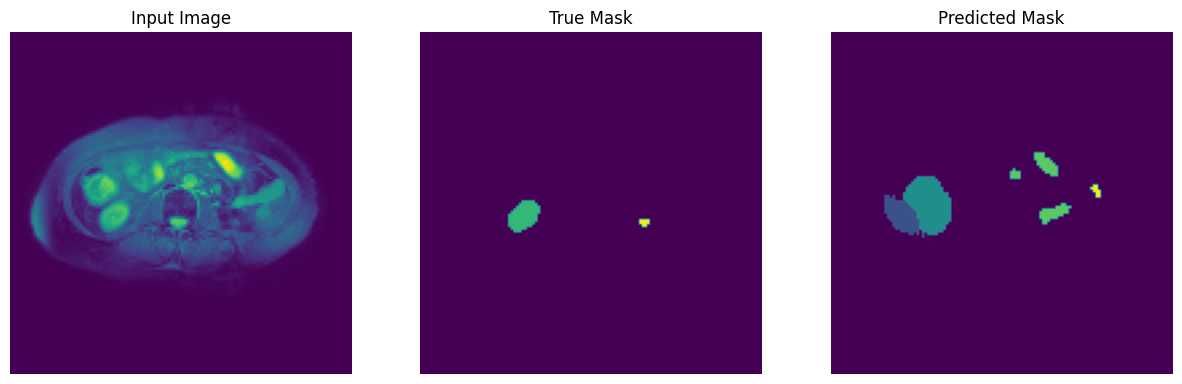


Sample Prediction after epoch 12

35/35 [==============================] - 28s 794ms/step - loss: 0.0048 - accuracy: 0.9702 - val_loss: 0.1119 - val_accuracy: 0.9551
Epoch 13/20
35/35 [==============================] - ETA: 0s - loss: 0.0044 - accuracy: 0.9723
Epoch 13: loss improved from 0.00483 to 0.00438, saving model to chaos19_unet.keras
1/1 [==============================] - 0s 46ms/step


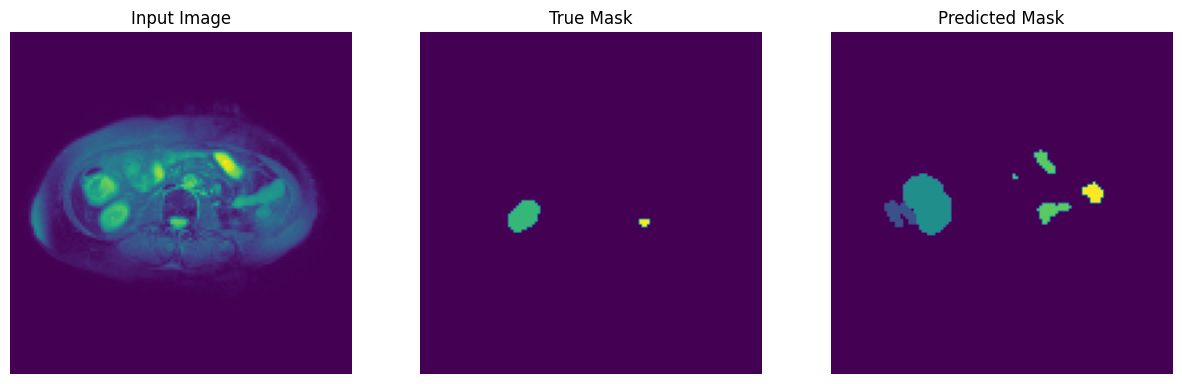


Sample Prediction after epoch 13

35/35 [==============================] - 28s 797ms/step - loss: 0.0044 - accuracy: 0.9723 - val_loss: 0.0973 - val_accuracy: 0.9622
Epoch 14/20
35/35 [==============================] - ETA: 0s - loss: 0.0041 - accuracy: 0.9735
Epoch 14: loss improved from 0.00438 to 0.00412, saving model to chaos19_unet.keras
1/1 [==============================] - 0s 45ms/step


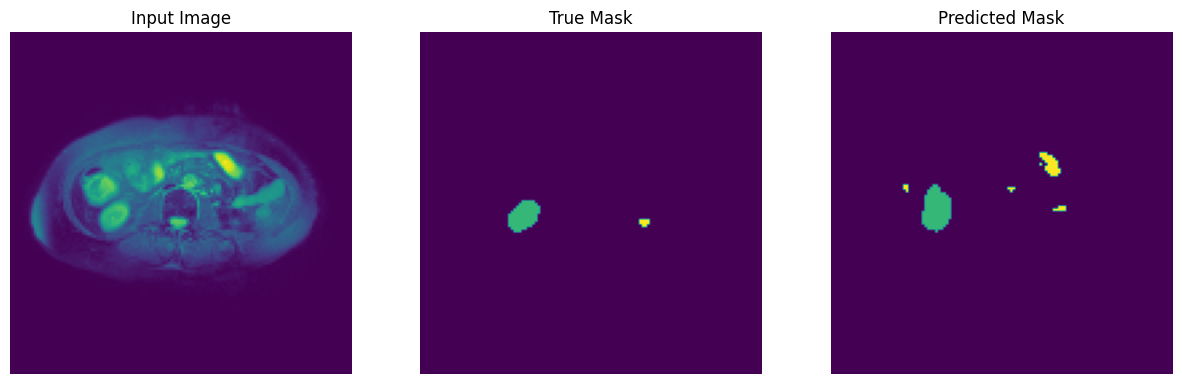


Sample Prediction after epoch 14

35/35 [==============================] - 22s 641ms/step - loss: 0.0041 - accuracy: 0.9735 - val_loss: 0.0792 - val_accuracy: 0.9708
Epoch 15/20
35/35 [==============================] - ETA: 0s - loss: 0.0035 - accuracy: 0.9772
Epoch 15: loss improved from 0.00412 to 0.00349, saving model to chaos19_unet.keras
1/1 [==============================] - 0s 68ms/step


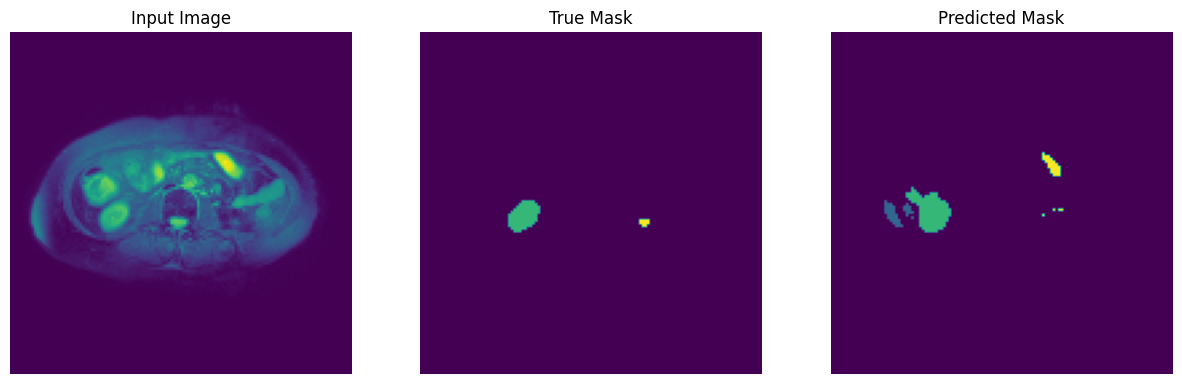


Sample Prediction after epoch 15

35/35 [==============================] - 23s 646ms/step - loss: 0.0035 - accuracy: 0.9772 - val_loss: 0.0848 - val_accuracy: 0.9708
Epoch 16/20
35/35 [==============================] - ETA: 0s - loss: 0.0034 - accuracy: 0.9784
Epoch 16: loss improved from 0.00349 to 0.00337, saving model to chaos19_unet.keras
1/1 [==============================] - 0s 50ms/step


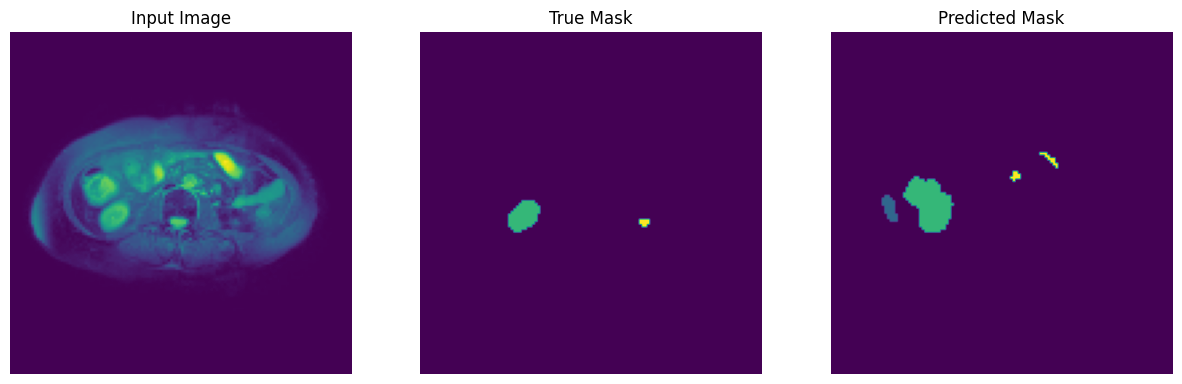


Sample Prediction after epoch 16

35/35 [==============================] - 26s 758ms/step - loss: 0.0034 - accuracy: 0.9784 - val_loss: 0.0845 - val_accuracy: 0.9670
Epoch 17/20
35/35 [==============================] - ETA: 0s - loss: 0.0030 - accuracy: 0.9800
Epoch 17: loss improved from 0.00337 to 0.00305, saving model to chaos19_unet.keras
1/1 [==============================] - 0s 44ms/step


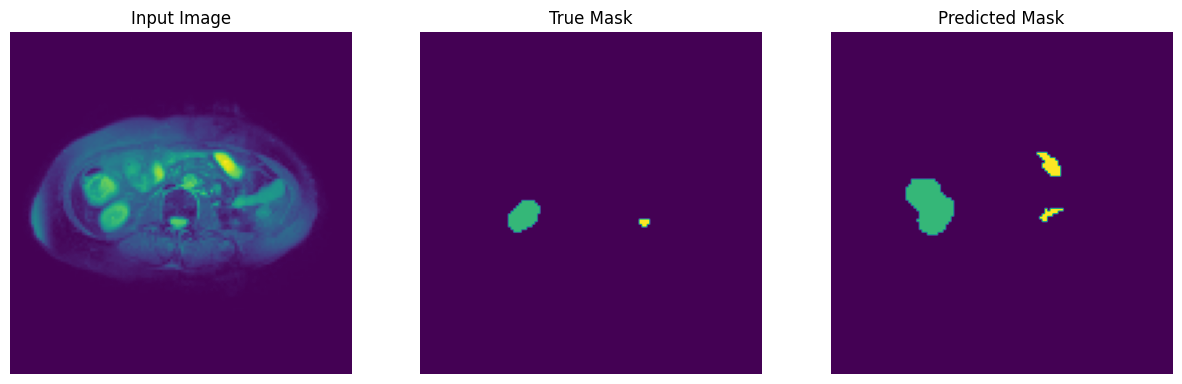


Sample Prediction after epoch 17

35/35 [==============================] - 22s 631ms/step - loss: 0.0030 - accuracy: 0.9800 - val_loss: 0.0764 - val_accuracy: 0.9715
Epoch 18/20
35/35 [==============================] - ETA: 0s - loss: 0.0030 - accuracy: 0.9805
Epoch 18: loss improved from 0.00305 to 0.00295, saving model to chaos19_unet.keras
1/1 [==============================] - 0s 47ms/step


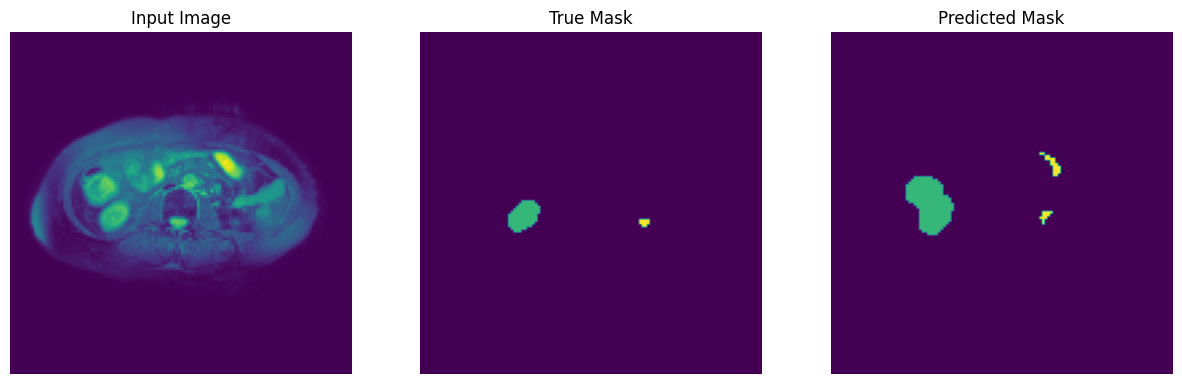


Sample Prediction after epoch 18

35/35 [==============================] - 23s 646ms/step - loss: 0.0030 - accuracy: 0.9805 - val_loss: 0.0567 - val_accuracy: 0.9775
Epoch 19/20
35/35 [==============================] - ETA: 0s - loss: 0.0029 - accuracy: 0.9810
Epoch 19: loss improved from 0.00295 to 0.00292, saving model to chaos19_unet.keras
1/1 [==============================] - 0s 46ms/step


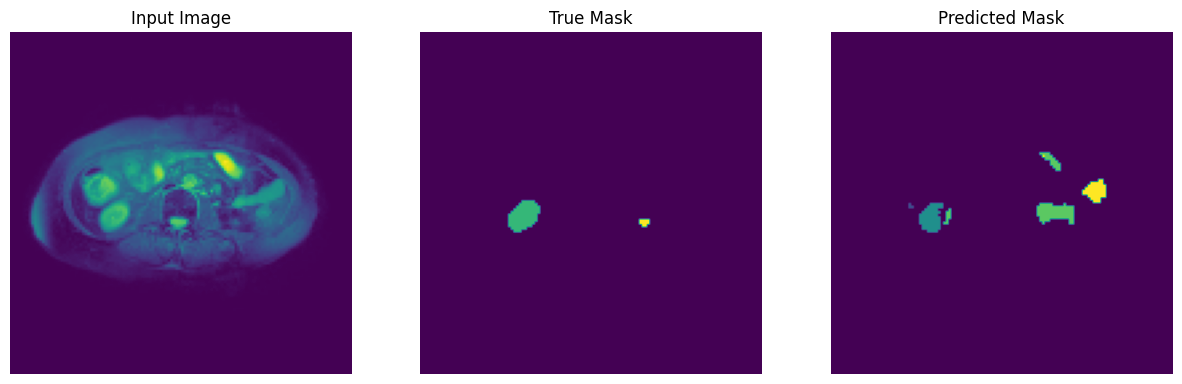


Sample Prediction after epoch 19

35/35 [==============================] - 22s 634ms/step - loss: 0.0029 - accuracy: 0.9810 - val_loss: 0.0874 - val_accuracy: 0.9683
Epoch 20/20
35/35 [==============================] - ETA: 0s - loss: 0.0038 - accuracy: 0.9768
Epoch 20: loss did not improve from 0.00292
1/1 [==============================] - 0s 81ms/step


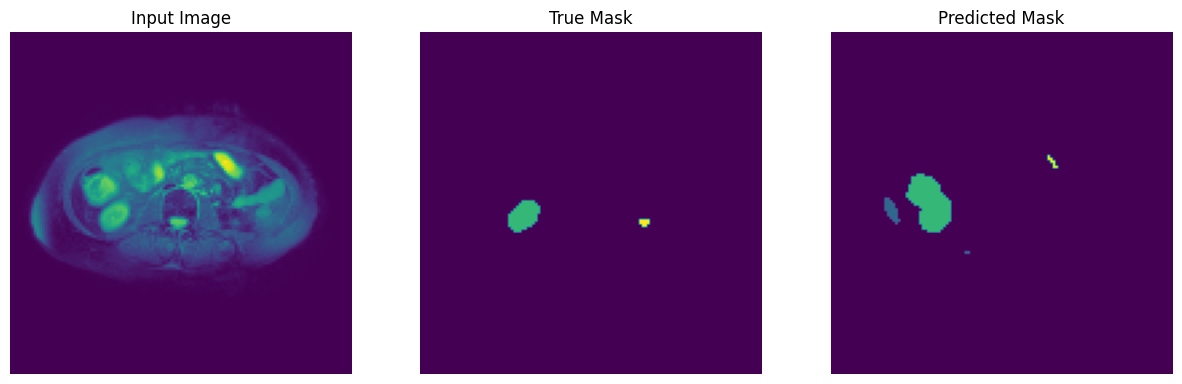


Sample Prediction after epoch 20

35/35 [==============================] - 20s 566ms/step - loss: 0.0038 - accuracy: 0.9768 - val_loss: 0.0602 - val_accuracy: 0.9766


In [77]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['validation'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

# model_history = unet_model.fit(train_batches, epochs=EPOCHS,

model_checkpoint = ModelCheckpoint('chaos19_unet.keras', monitor='loss', verbose=1, save_best_only = True)
model_history = unet_model.fit(train_batches.map(add_sample_weights), epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=validation_batches,
                          callbacks=[model_checkpoint, DisplayCallback()])

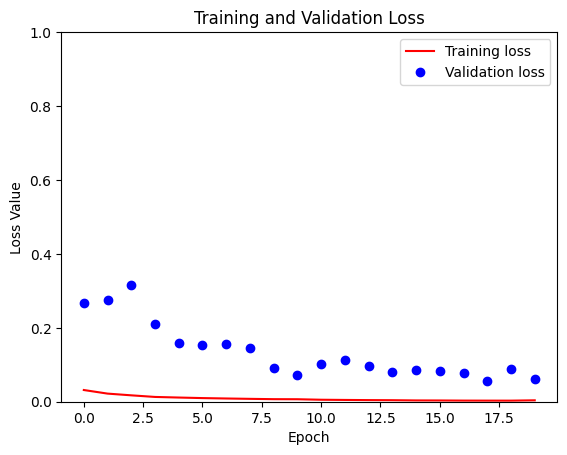

In [81]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

1/1 [==============================] - 0s 53ms/step


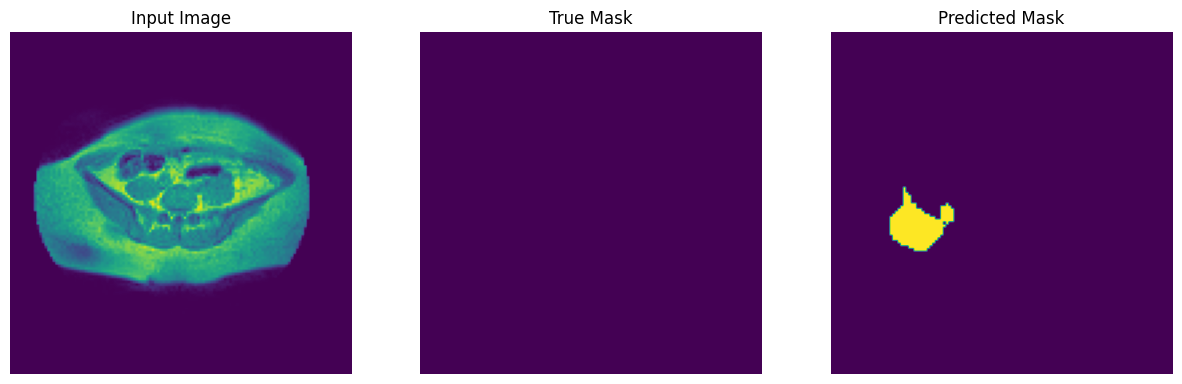

1/1 [==============================] - 0s 46ms/step


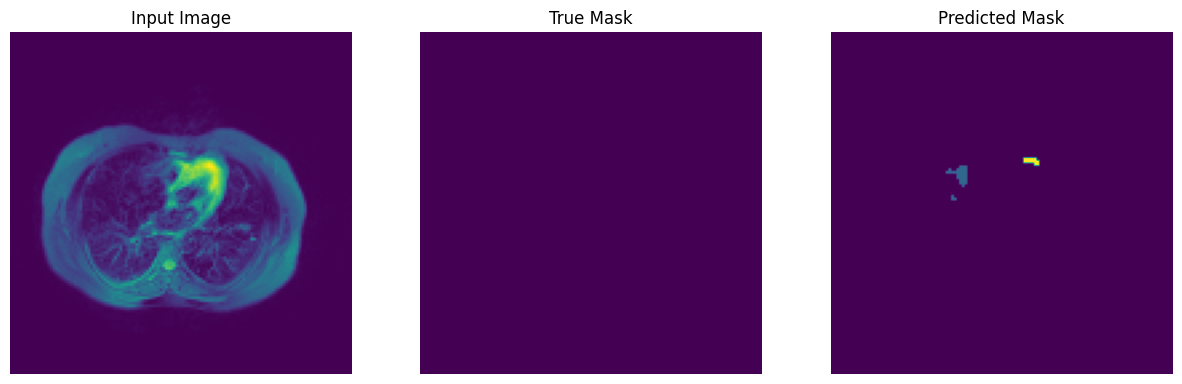

1/1 [==============================] - 0s 44ms/step


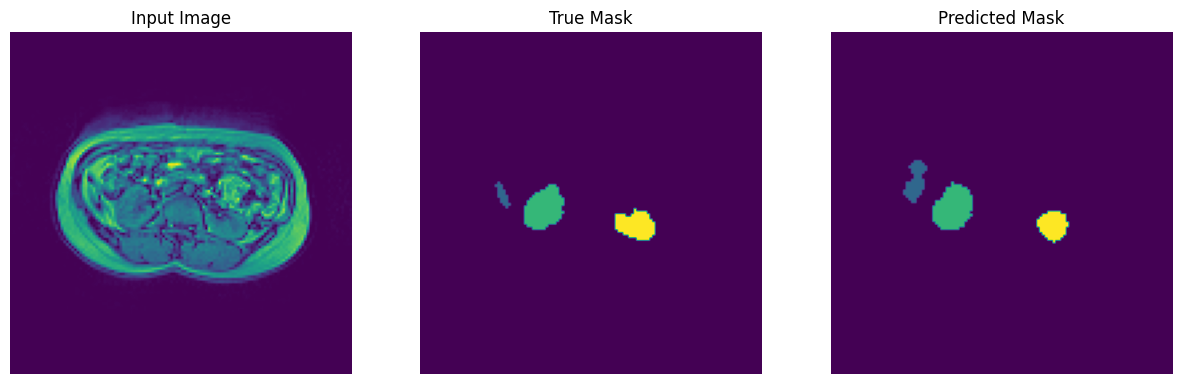

1/1 [==============================] - 0s 45ms/step


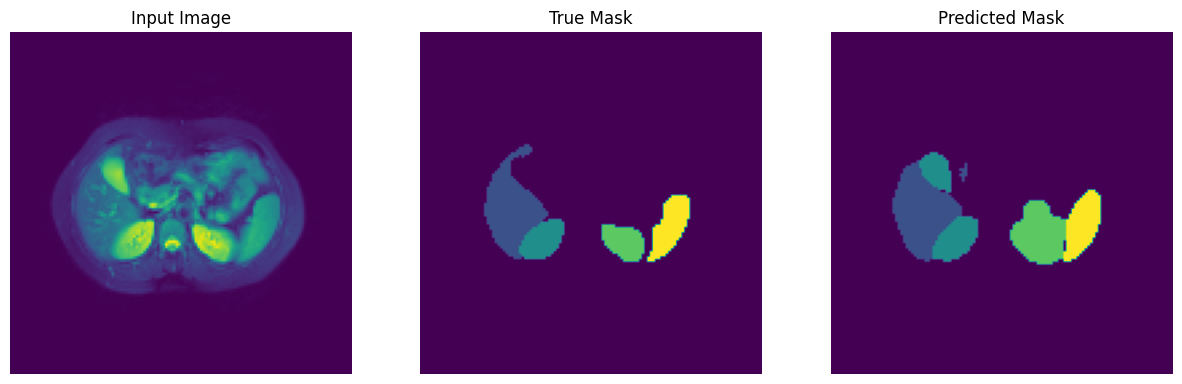

1/1 [==============================] - 0s 43ms/step


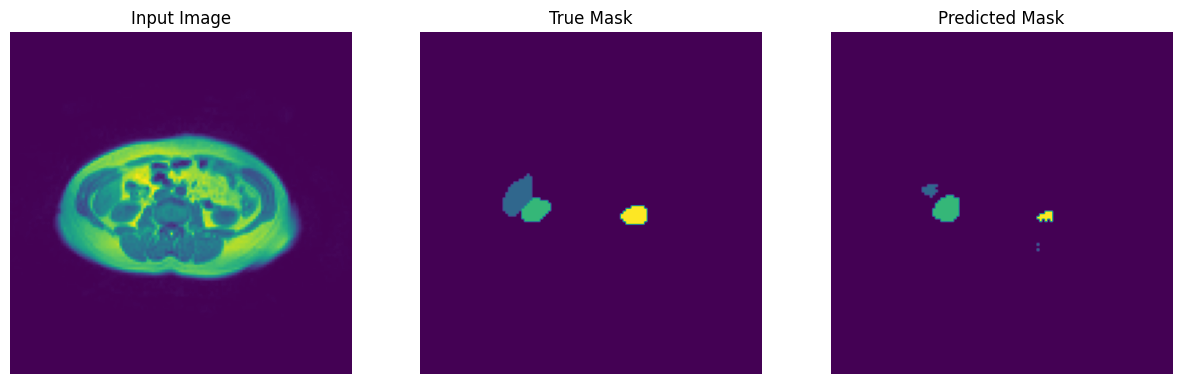

1/1 [==============================] - 0s 48ms/step


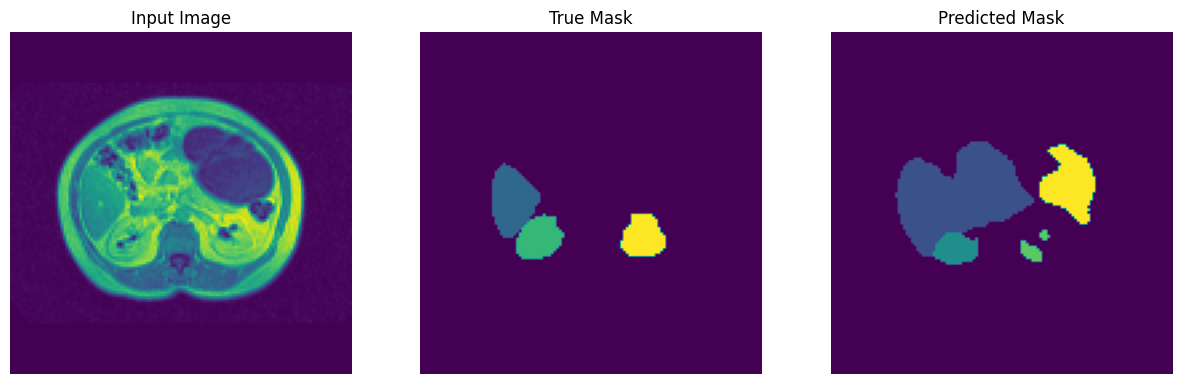

1/1 [==============================] - 0s 44ms/step


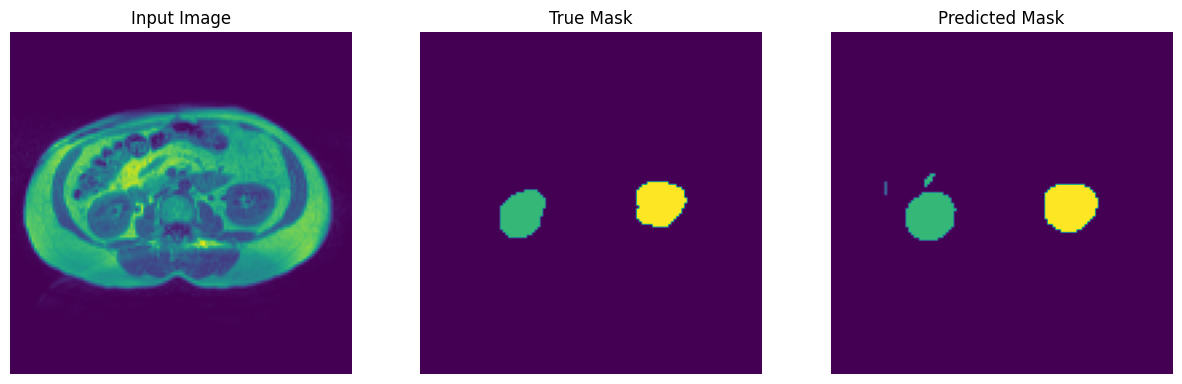

1/1 [==============================] - 0s 44ms/step


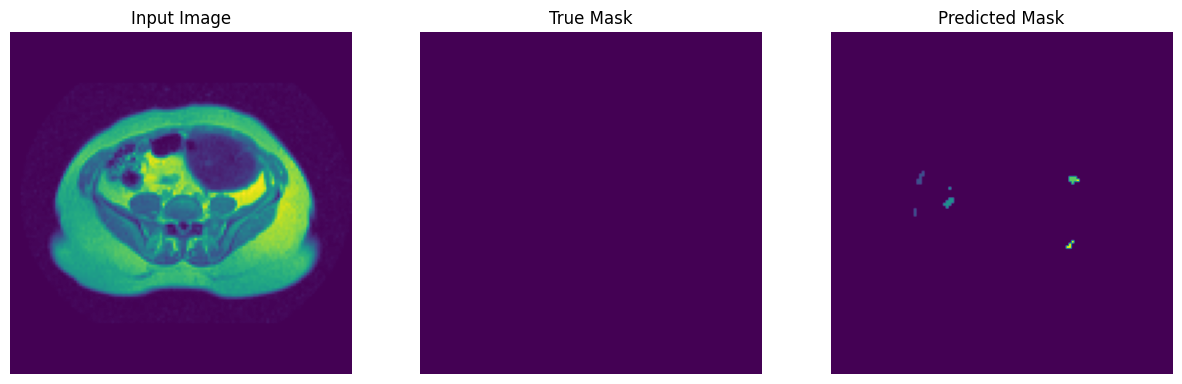

1/1 [==============================] - 0s 43ms/step


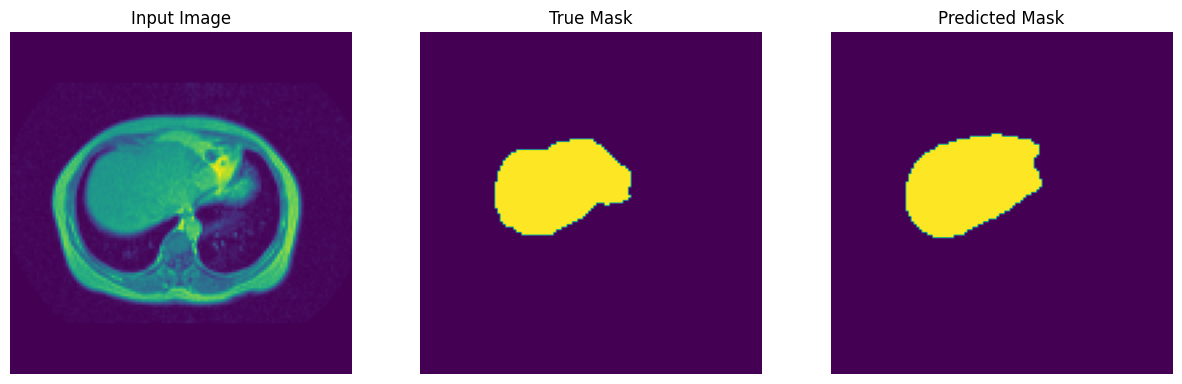

1/1 [==============================] - 0s 52ms/step


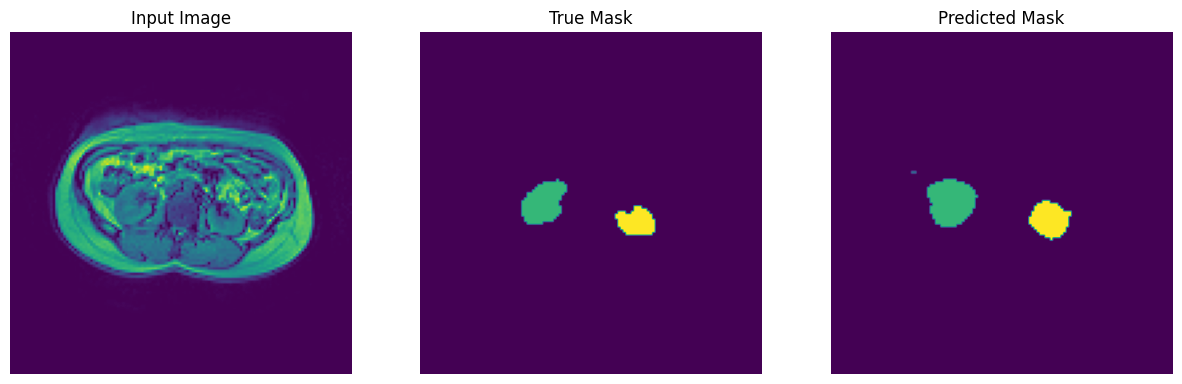

1/1 [==============================] - 0s 66ms/step


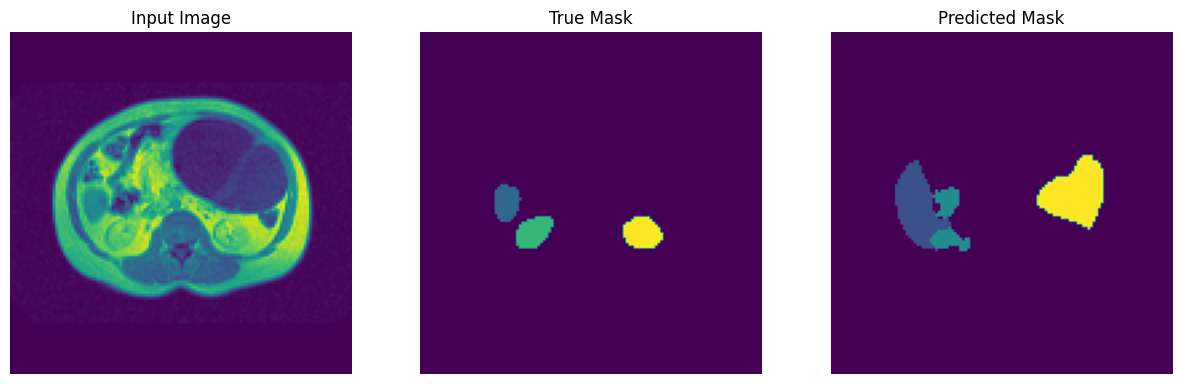

1/1 [==============================] - 0s 90ms/step


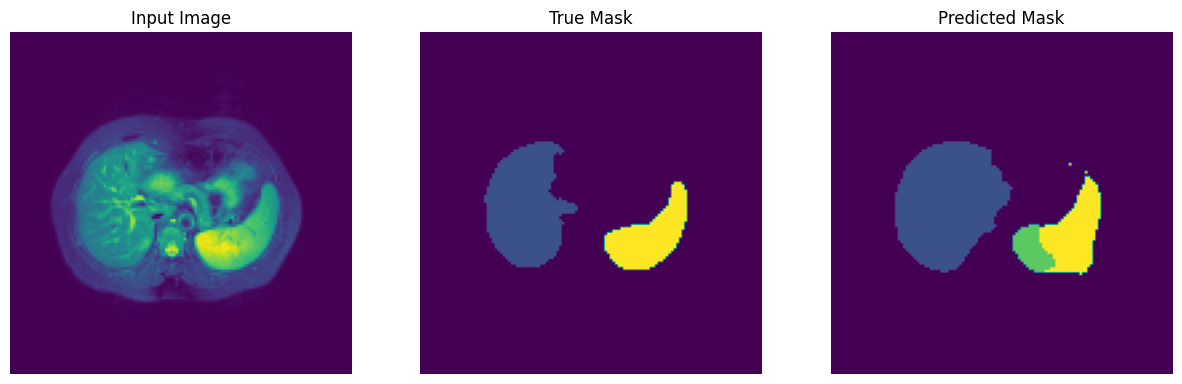

1/1 [==============================] - 0s 61ms/step


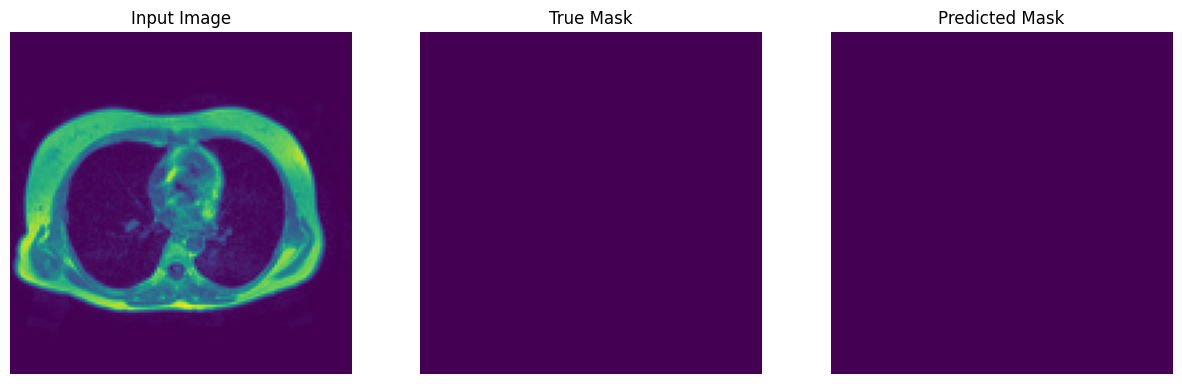

In [80]:
model = build_unet_model()
model.load_weights("chaos19_unet.keras")
show_predictions(test_batches, 20)

# show_predictions(test_batches, 30)